Found datastructure of shape (60000, 28, 28)


/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


Found datastructure of shape (60000,)
Found datastructure of shape (10000, 28, 28)
Found datastructure of shape (10000,)


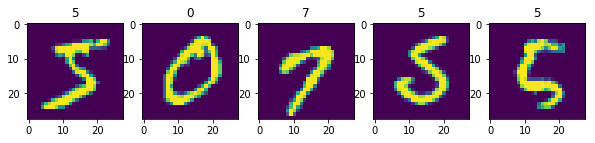

In [2]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def read_gz(filename):
    with gzip.open(filename) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        print("Found datastructure of shape", shape)
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

def plot_mnist(images, labels):
    N = len(labels)
    fig, ax = plt.subplots(ncols=N, figsize=(2*N, 2))
    for i in range(N):
        ax[i].imshow(images[i])
        ax[i].set_title(str(labels[i]))
    plt.show()

pwd = "/home/aleksejs/Downloads/mnist_data/"
train_images = read_gz(pwd + "train-images-idx3-ubyte.gz")
train_labels = read_gz(pwd + "train-labels-idx1-ubyte.gz")
test_images = read_gz(pwd + "t10k-images-idx3-ubyte.gz")
test_labels = read_gz(pwd + "t10k-labels-idx1-ubyte.gz")

select_images = [0,1, 15, 138, 2000]
plot_mnist(train_images[select_images], train_labels[select_images])

In [4]:
# Prepare data for analysis

# Flatten the pixels to 1D arrays
nDataTrain, nPixX, nPixY = train_images.shape
nDataTest = test_images.shape[0]
nPix2D = train_images.shape[1:]
nPixFlat = nPixX * nPixY
train_data_flat = train_images.reshape(nDataTrain, nPixFlat) / 255
test_data_flat = test_images.reshape(nDataTest, nPixFlat) / 255

def labels2binary(labels, nDigits):
    labels_bin = np.zeros((labels.shape[0], nDigits))
    for i, label in enumerate(labels):
        labels_bin[i, label] = 1
    return labels_bin

# Convert labels to binary form
nDigits = 10
train_labels_bin = labels2binary(train_labels, nDigits)
test_labels_bin = labels2binary(test_labels, nDigits)

# Using Linear Classifier + PCA

Ok, let's train a linear classifier. We will train a classifier of the form

$$y_{ij} = U_{jk}x_{ik}$$

where $x$ is the image vector, $y$ is the digit, and $U$ is the map between them. The loss function will be defined as

$$L = \sum_{ij} \biggl| y_{ij} - \sum_{k} U_{jk} x_{ik} \biggr|^2$$

We can solve the optimization problem exactly by taking the derivative with respect to $U$

$$\frac{\partial L}{\partial U_{mn}} = -2 \sum_i \biggl( y_{im} - \sum_k U_{mk} x_{ik} \biggr)x_{in} = 0$$

So the optimal $U$ is

$$U = B A^{-1}$$

where $A_{kn} = \sum_i x_{ik} x_{in}$ and $B_{mn} = \sum_i y_{im} x_{in}$

In [5]:
# Compute least squares matrices
def lsq_matrices(data, labels):
    nData = data.shape[0]
    A = data.T.dot(data)
    B = labels.T.dot(data)
    return A / nData, B / nData

In [6]:
%%time
print("This operation may take time, wait...")
A, B = lsq_matrices(train_data_flat, train_labels_bin)

This operation may take time, wait...
CPU times: user 2.2 s, sys: 316 ms, total: 2.51 s
Wall time: 361 ms


/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


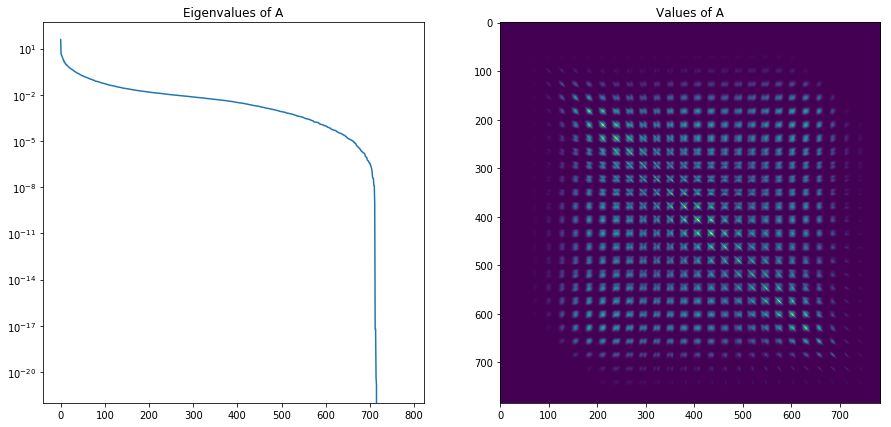

In [7]:
evalA = np.flip(np.sort(np.linalg.eig(A)[0]))

fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax[0].set_title("Eigenvalues of A")
ax[0].semilogy(evalA)
ax[1].set_title("Values of A")
ax[1].imshow(A)
plt.show()

**FAIL!** The matrix is singular. This is because the there are too many pixels that do essentially the same thing, so there is no unique way to do a least squares fit. Let's do some dimensionality reduction first

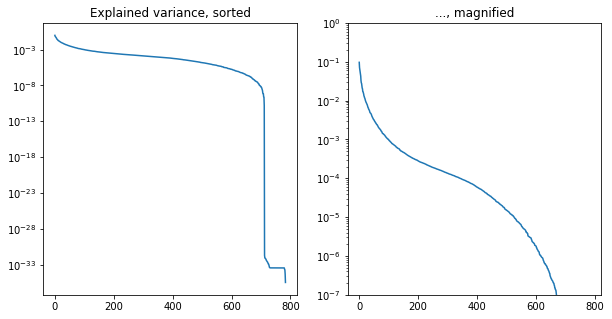

For threshold 0.001 the number of informative PCA are 100


In [8]:
# Perform PCA
pca = PCA()
data_pca_training = pca.fit_transform(train_data_flat)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].set_title("Explained variance, sorted")
ax[1].set_title("..., magnified")
ax[0].semilogy(pca.explained_variance_ratio_)
ax[1].semilogy(pca.explained_variance_ratio_)
ax[1].set_ylim([1.0e-7, 1.0])
plt.show()

# Apply threshold based on explained variance
explVarThreshold = 1.0e-3
selected_pca = pca.explained_variance_ratio_ > explVarThreshold
nPCASelected = np.sum(selected_pca)
print("For threshold", explVarThreshold, "the number of informative PCA are", nPCASelected)
data_pca_training_selected = data_pca_training[:, selected_pca]

# Perform selection also for the testing data set
data_pca_testing = pca.transform(test_data_flat)
data_pca_testing_selected = data_pca_testing[:, selected_pca]

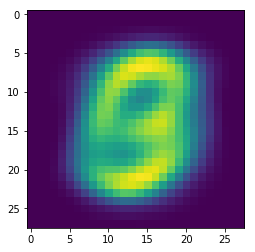

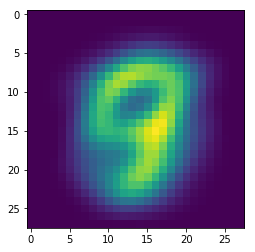

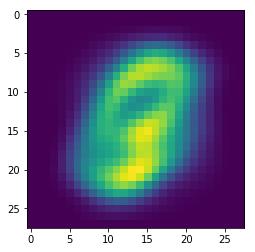

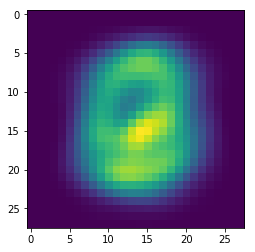

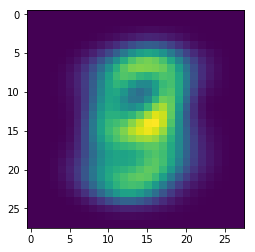

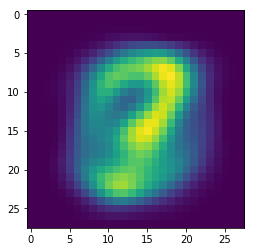

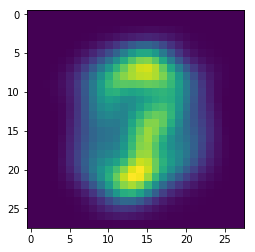

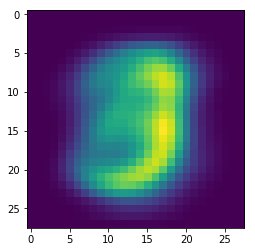

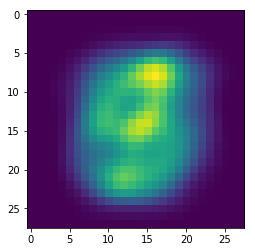

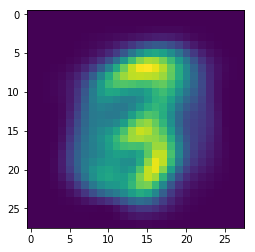

In [9]:
# Plot the informative PCA's
selected_pca_idxs = np.where(selected_pca)[0]
selected_pcas = labels2binary(selected_pca_idxs, nPixFlat)

for iPCA in range(10):
    plt.figure()
    plt.imshow(pca.inverse_transform(selected_pcas[iPCA]).reshape((nPixX, nPixY)))
plt.show()

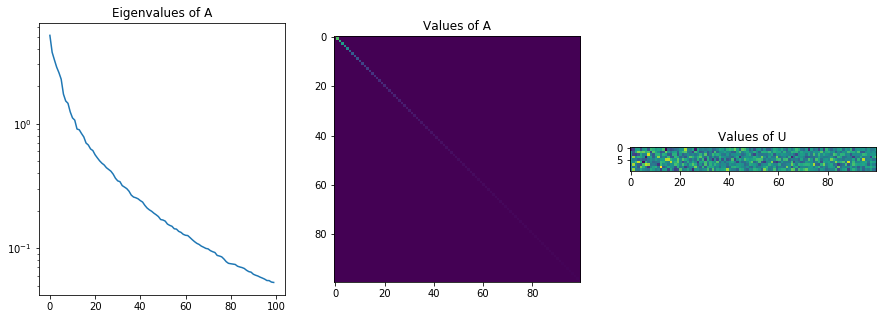

In [58]:
# Redo Least-Squares using only PCA
A, B = lsq_matrices(data_pca_training_selected, train_labels_bin)
U = B.dot(np.linalg.inv(A))

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].set_title("Eigenvalues of A")
ax[0].semilogy(np.flip(np.sort(np.linalg.eig(A)[0])))
ax[1].set_title("Values of A")
ax[1].imshow(A)
ax[2].set_title("Values of U")
ax[2].imshow(U)
plt.show()

Now we can see how well does the classifier predict the labels for training and for testing data. We can calculate the predicted values
$$\hat{y} = Ux$$
Then just take the value that is closest to 1

$$\mathrm{digit} = \mathrm{argmin} |\hat{y} - 1|$$

In [75]:
############################
#  Testing Accuracy
############################
def predict(img, U):
    return np.argmax(img.dot(U.T), axis=1)

training_predictions = predict(data_pca_training_selected, U) == train_labels
testing_predictions = predict(data_pca_testing_selected, U) == test_labels

print("Accuracy on training dataset is:", np.mean(training_predictions))
print("Accuracy on testing dataset is:", np.mean(testing_predictions))

Accuracy on training dataset is: 0.8533666666666667
Accuracy on testing dataset is: 0.8627


Ok, so we get 85% accuracy on both training and testing, that's pretty good. Most naive classifier LeCun used had 88% accuracy, but it is possible to go up to 99.5% with more fancy methods, apparently.

**Next Level**: Test how does number of PCA affect prediction accuracy

**Really Puzzling** - Increasing PCA to max does not seem to hurt accuracy at all. How??? Some PCA's are effectively pure noise due to roundoff errors, the kernel should be singular or sth

1.0
4.601134146683004
9.102393506021894
14.74662846480862
21.24735584638029
30.42051934212885
40.35100584967575
51.90296641133747
68.29738631845785
82.92142504768638
98.62290463757174
122.59799650537528
139.55023427149553
160.78274610234476
184.81793559147974
207.987270918938
233.558321318952
262.70388917080976
287.8919288428428
317.18075916077385
344.1782180438201
375.33957446935483
402.73639808858167
437.4169574882546
474.0365709229265
506.6600583112469
546.5699822277884
581.3900375775174
619.165783884772
670.8956503150866
714.6543487264822
768.1466779065818
823.3213066680738
881.7708478960881
951.0102265818485
1034.6320332528655
1111.290054390172
1199.5409892306861
1319.1218869574413
1447.191712793466
1634.6613272161137
1819.7331460879902
2024.2438832486162
2301.0882595937005
2617.629653739738
3014.0133374327825
3457.9154950016605
3991.369278590221
4606.490310106514
5360.955687433342
6398.522377718539
7405.911090984669
8629.158399020676
10523.09212159263
12884.672784149203
15805.891

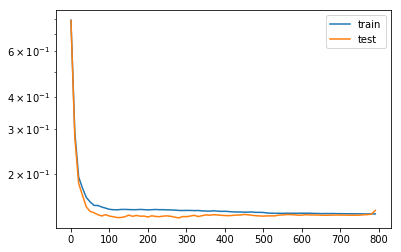

In [87]:
nPCAlst = np.arange(1, 800, 10)
acc_train = []
acc_test = []

for nPCA in nPCAlst:
    data_pca_training_this = data_pca_training[:, :nPCA]
    data_pca_testing_this = data_pca_testing[:, :nPCA]
    
    # Redo Least-Squares using only PCA
    A, B = lsq_matrices(data_pca_training_this, train_labels_bin)
    U = B.dot(np.linalg.inv(A))
    print(np.linalg.cond(A))
    
    training_predictions = predict(data_pca_training_this, U) == train_labels
    testing_predictions = predict(data_pca_testing_this, U) == test_labels

    acc_train += [1 - np.mean(training_predictions)]
    acc_test += [1 - np.mean(testing_predictions)]
    
plt.figure()
plt.semilogy(nPCAlst, acc_train, label='train')
plt.semilogy(nPCAlst, acc_test, label='test')
plt.legend()
plt.show()

# Using SGD

1. Initialize U randomly
2. Show 1 image at a time
3. Update U usin gradient descent (for some positive learning rate $\zeta$)

$$\Delta U = - \zeta \partial_U L = \zeta \sum_i (y_i - Ux_i)x_i^T$$

**Conclusions**:
* Much simpler than PCA, but also much worse - only 65% accuracy
* Presenting images randomly is much better than presenting one image several times in a row - not sure why.
* Highly sensitive to learning rate - explodes if too large, does not learn at all if too small. Good learning rate within 1 order of magnitude

2034.0722701025154


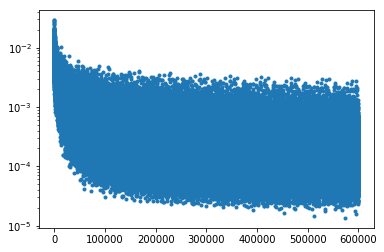

In [58]:
U_SGD = np.random.uniform(-1, 1, N_DIGIT*N_PIXEL).reshape((N_DIGIT, N_PIXEL))
U_SGD /= np.linalg.norm(U_SGD)

zeta = 0.0000001
N_REPS = N_DATA_TRAIN*10
DU_ARR = np.zeros(N_REPS)
for i in range(N_REPS):
    idx = i % N_DATA_TRAIN #np.random.randint(0, N_DATA_TRAIN)
    x = train_images[idx].flatten()
    y = np.zeros(N_DIGIT)
    y[train_labels[idx]] = 1
    
    DU = zeta*np.outer(y - U_SGD.dot(x), x)
    U_SGD += DU
    DU_ARR[i] = np.linalg.norm(DU)
    
print(np.linalg.norm(train_images[idx].flatten()))
    
plt.figure()
plt.semilogy(DU_ARR, '.')
plt.show()

In [59]:
training_predictions = [predict(train_images[i].flatten(), U_SGD) == train_labels[i] for i in range(N_DATA_TRAIN)]
testing_predictions = [predict(test_images[i].flatten(), U_SGD) == test_labels[i] for i in range(N_DATA_TEST)]

print("Accuracy on training dataset is:", np.sum(training_predictions) / N_DATA_TRAIN)
print("Accuracy on testing dataset is:", np.sum(testing_predictions) / N_DATA_TEST)

Accuracy on training dataset is: 0.6830833333333334
Accuracy on testing dataset is: 0.6799
